# The Rekall Auto-Tuner

Rekall queries often have a lot of "magic numbers" that need to be tuned to get the best performance. The Rekall [tuner package](https://rekallpy.readthedocs.io/en/latest/source/rekall.tuner.html) provides a number of tuning algorithms that will help you select the best parameters for your query given some ground truth annotations.

This notebook will help introduce you to the tuner package's API, and walk you through the tuning of a query for the parking space detection task.

## The Tuner API

Here's an example of what a call to the tuner API looks like:

```Python
from rekall.tuner import Random Tuner

def eval_config(params):
    # Run the Rekall query
    query_results = query(params)

    # Evaluate the results
    score = evaluate(query_results)

    return score

search_space = {
    'param1': [0.0, 1.0, 2.0],          # discrete
    'param2': { 'range': (10.0, 20.0) } # linear range
}

tuner = RandomTuner(search_space, eval_config, budget = 50)

best_score, best_config, score_history, execution_times, total_cost = tuner.tune()
```

You define a search space of parameters to search through, and give it a function that runs the Rekall query and returns a score to optimize (we assume you want to maximize the score).

You pick a tuner (we picked `RandomTuner` in this example) and give it a budget, and the tuning algorithm will search through the search space and return the best score, as well as the best parameter configuration it found.

Here's a list of tuners that we provide as of this writing (see the [documentation](https://rekallpy.readthedocs.io/en/latest/source/rekall.tuner.html) for details and for the most up-to-date list):
* `RandomTuner`
* `GridTuner`
* `CoordinateDescentTuner`
* `SuccessiveHalvingTuner`
* `HyperbandTuner`

Anecdotally, we have observed that running the `CoordinateDescentTuner` from a few random initializations, or running the `HyperbandTuner` with the `CoordinateDescentTuner` in the inner loop tend to work the best.

## An example: tuning an empty parking space detection query

Let's tune an empty parking space detection query as an example. We'll load up some ground truth annotations (some tips on collecting those at the bottom of this notebook), put together a simple query with some magic numbers, and see how well we can do.

### Load Data

In [1]:
from rekall import Interval, IntervalSet, IntervalSetMapping, Bounds3D
from rekall.predicates import *
from vgrid import VGridSpec, VideoMetadata, VideoBlockFormat, FlatFormat, SpatialType_Bbox
from vgrid_jupyter import VGridWidget
import urllib3, requests, os
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Hack to disable warnings about olimar's certificate
urllib3.disable_warnings()

# Parking lot data
VIDEO_COLLECTION_BASEURL = "https://olimar.stanford.edu/hdd/parking_lot/user_study"
VIDEO_METADATA_FILENAME = 'metadata.json'

# Load video file metadata
video_metadata = [ VideoMetadata(v['filename'], id=v['id'], fps=v['fps'],
                                 num_frames=v['num_frames'], width=v['width'],
                                 height=v['height'])
                  for v in requests.get(os.path.join(
                      VIDEO_COLLECTION_BASEURL, VIDEO_METADATA_FILENAME),
                                        verify=False).json() ]

VIDEO_FOLDER = 'videos'
BBOX_FOLDER = 'bboxes'
GT_FOLDER = 'empty_spaces'

dev_set = requests.get(
    os.path.join(VIDEO_COLLECTION_BASEURL, 'dev.txt'), verify=False
).content.decode('utf-8').strip().split('\n')

video_metadata_dev = [
    vm
    for vm in video_metadata if vm.path in dev_set
]

video_metadata = video_metadata_dev

interval = 30
bboxes = [
    pickle.loads(requests.get(
        os.path.join(
            os.path.join(VIDEO_COLLECTION_BASEURL, BBOX_FOLDER),
            os.path.join(vm.path[:-4], 'bboxes.pkl')
        ),
        verify=False
    ).content)
    for vm in (video_metadata)
]
bboxes_ism = IntervalSetMapping({
    metadata.id: IntervalSet([
        Interval(
            Bounds3D(
                t1 = 30 * i / metadata.fps,
                t2 = 30 * (i + interval) / metadata.fps,
                x1 = bbox[0] / metadata.width,
                x2 = bbox[2] / metadata.width,
                y1 = bbox[1] / metadata.height,
                y2 = bbox[3] / metadata.height
            ),
            payload = { 'class': bbox[4], 'score': bbox[5] }
        )
        for i, frame in enumerate(bbox_frame_list) if (i % interval == 0)
        for bbox in frame
    ])
    for bbox_frame_list, metadata in tqdm(
        zip(bboxes, (video_metadata)),
        total = len(bboxes))
})

def visualize_helper(box_list):
    vgrid_spec = VGridSpec(
        video_meta = video_metadata,
        vis_format = VideoBlockFormat(imaps = [
            (str(i), box)
            for i, box in enumerate(box_list)
        ]),
        video_endpoint = os.path.join(VIDEO_COLLECTION_BASEURL, VIDEO_FOLDER)
    )
    return VGridWidget(vgrid_spec = vgrid_spec.to_json_compressed())

100%|██████████| 2/2 [00:00<00:00, 36.42it/s]


### Load and Visualize Ground Truth

Load up some ground truth annotations

In [2]:
GT_FOLDER = 'empty_spaces'

empty_parking_spaces = [
    pickle.loads(requests.get(
        os.path.join(
            os.path.join(VIDEO_COLLECTION_BASEURL, GT_FOLDER),
            os.path.join(vm.path[:-4], 'gt.pkl')
        ),
        verify=False
    ).content)
    for vm in video_metadata
]
gt_ism = IntervalSetMapping({
    metadata.id: IntervalSet([
        Interval(
            Bounds3D(
                t1 = 30 * i / metadata.fps,
                t2 = 30 * (i + interval) / metadata.fps,
                x1 = bbox[0] / metadata.width + .01,
                x2 = bbox[2] / metadata.width - .01,
                y1 = bbox[1] / metadata.height + .01,
                y2 = bbox[3] / metadata.height - .01
            )
        )
        for i, frame in enumerate(space_frame_list) if (i % interval == 0)
        for bbox in frame
    ])
    for space_frame_list, metadata in tqdm(
        zip(empty_parking_spaces, video_metadata),
        total = len(empty_parking_spaces))
})

100%|██████████| 2/2 [00:00<00:00, 463.72it/s]


### Parking Spaces Query

Here's an example parking spaces query, with some magic numbers.

In [3]:
def parking_spaces_query(bboxes_ism, params={}):
    magic_numbers = {
        'EMPTY_SPOT_IOU': 0.25,
        'COALESCE_IOU': 0.5,
        'MIN_TIME': 30
    }
    
    magic_numbers.update(params)
    
    EMPTY_SPOT_IOU = magic_numbers['EMPTY_SPOT_IOU']
    COALESCE_IOU = magic_numbers['COALESCE_IOU']
    MIN_TIME = magic_numbers['MIN_TIME']
    
    first_key = sorted(list(bboxes_ism.keys()))[0]
    parking_spot_candidates = bboxes_ism[first_key].filter(
        lambda intrvl: intrvl['t1'] == 0.0 and intrvl['payload']['class'] == 'car'
    )
    
    video_durations = bboxes_ism.coalesce(
        axis=('t1', 't2'),
        bounds_merge_op=Bounds3D.span
    )
    
    parking_spots = IntervalSetMapping({
        key: IntervalSet([
            Interval(Bounds3D(
                t1 = t,
                t2 = t + interval,
                x1 = parking_spot['x1'],
                x2 = parking_spot['x2'],
                y1 = parking_spot['y1'],
                y2 = parking_spot['y2']
            ))
            for parking_spot in parking_spot_candidates.get_intervals()
            for t in range(0, int(video_durations[key].get_intervals()[0]['t2']), interval)
        ])
        for key in video_durations
    })
    
    empty_parking_spots = parking_spots.minus(
        bboxes_ism.filter(
            lambda intrvl: intrvl['payload']['class'] in ['car', 'truck']
        ),
        predicate = and_pred(
            Bounds3D.T(overlaps()),
            Bounds3D.X(overlaps()),
            Bounds3D.Y(overlaps()),
            iou_at_least(EMPTY_SPOT_IOU)
        ),
        window=0.0
    )
    
    # Get rid of predictions that are empty for less than four minutes
    empty_spots_coalesced_and_filtered = empty_parking_spots.map(
        lambda intrvl: Interval(intrvl['bounds'], [intrvl])
    ).coalesce(
        ('t1', 't2'),
        bounds_merge_op = Bounds3D.span,
        payload_merge_op = lambda p1, p2: p1 + p2,
        predicate = iou_at_least(COALESCE_IOU)
    ).filter_size(min_size=MIN_TIME).split(
        lambda intrvl: IntervalSet(intrvl['payload'])
    )
    
    return empty_spots_coalesced_and_filtered

### Visualize Example Results

(this will take a few seconds)

In [4]:
parking_spaces_result = parking_spaces_query(bboxes_ism)

In [5]:
visualize_helper([
    parking_spaces_result,
    gt_ism
])

VGridWidget(vgrid_spec={'compressed': True, 'data': b'x\x9c\xdd\x9d\xcdn\x1bI\x12\x84_\xc5\xd0yau\xfdW\xf9\xb8…

### Computing Average Precision

This is a function that computes average precision based on the ground truth (you may need to install scikit-learn in your environment to run this).

In [6]:
from sklearn.metrics import average_precision_score
import numpy as np

def evaluate_preds(predictions, gt):
    true_positives = predictions.filter_against(
        gt,
        predicate = and_pred(
            Bounds3D.T(equal()),
            iou_at_least(0.5)
        ),
        window = 0.0
    )
    false_positives = predictions.minus(
        true_positives,
        predicate = and_pred(
            Bounds3D.T(equal()),
            iou_at_least(0.5)
        ),
        window = 0.0
    )
    false_negatives = gt.minus(
        predictions,
        predicate = and_pred(
            Bounds3D.T(equal()),
            iou_at_least(0.5)
        ),
        window = 0.0
    )
    
    tp_count = sum(true_positives.size().values())
    fp_count = sum(false_positives.size().values())
    fn_count = sum(false_negatives.size().values())
    
    y_true = np.concatenate([
        np.ones(tp_count),
        np.zeros(fp_count),
        np.zeros(1000 * sum(gt.size().values())),
        np.ones(fn_count),
    ])
    y_scores = np.concatenate([
        np.ones(tp_count),
        np.ones(fp_count),
        np.ones(1000 * sum(gt.size().values())) - 0.1,
        np.zeros(fn_count),
    ])
    
    return average_precision_score(y_true, y_scores)

Now let's run it (this will take a few seconds).

In [7]:
evaluate_preds(parking_spaces_result, gt_ism)

0.8620689655172413

## Tuning the Query

To tune the query, you need to:
* Define a search space over query parameters
* Define a single function that will take in a configuration from the search space (a set of values) and evaluate the query results with those parameters

### Defining the search space

Example of a search space:

```Python
search_space = {
    'param1': [0.0, 1.0, 2.0],          # discrete
    'param2': { 'range': (10.0, 20.0) } # linear range
}
```

We'll define three continuous parameters for our query:

In [8]:
search_space = {
    'EMPTY_SPOT_IOU': { 'range': [0.1, 0.9] },
    'COALESCE_IOU': { 'range': [0.1, 0.9] },
    'MIN_TIME': { 'range': [10, 500] }
}

### Evaluating a configuration

This function will take a config, run the query with those parameters, and return the average precision score. The config will be of this format:

```Python
{
    'EMPTY_SPOT_IOU': value,
    'COALESCE_IOU': value,
    'MIN_TIME': value
}
```

Luckily, we wrote our query to take exactly this kind of input in the params argument.

In [9]:
def evaluate_config(config):
    query_results = parking_spaces_query(bboxes_ism, params = config)
    
    ap_score = evaluate_preds(query_results, gt_ism)
    
    return ap_score

### Tuning our query!

Let's tune our query with a few tuning algorithms!

In [10]:
from rekall.tuner import *

In [11]:
random_tuner = RandomTuner(search_space, evaluate_config, budget = 10)

In [12]:
(best_score, best_config, scores,
     execution_times, cost) = random_tuner.tune()

100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


Let's see how the best configs improved during our tuning session:

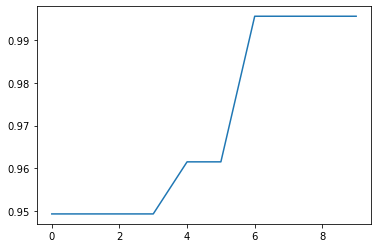

In [13]:
import matplotlib.pyplot as plt

def get_best_so_far(scores):
    best_so_far = []
    best = scores[0]
    
    for score in scores:
        if score > best:
            best = score
        best_so_far.append(best)
    
    return best_so_far

plt.plot(get_best_so_far(scores))

# Applying the Auto-Tuner in practice - gathering ground truth

If you've already gathered ground truth annotations for your task, that's great! You can go ahead and use it to write an evaluation function like we did above, and tune your parameters.

If you don't have ground truth already, click over to the Annotating Ground Truth notebook!